The following formats are used:
1. labelme: Format received from the .json files created with labelme
2. alb_in: Format that is inputed into the augmentor of albumentation
3. alb_out: Format that is ouputed from the augmentor of albumentations
4. keyrcnn_in: Format that is inputed into keypoint rcnn

This notebook take a labelme format as input, augments it, and save a set of augmented images and labels to disk.

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Thesis\\code_ver2')
import os
import time
import cv2
import tensorflow as tf
import numpy as np
import json
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
from helpers.formatting_functions import labelme_to_alb_in, alb_out_to_keyrcnn_in
from helpers import m
from helpers.draw_utils import draw_label_on_alb_output, draw_label_on_keyrcnn_in


In [2]:
# Create albumentations pipeline
augmentor = alb.Compose([alb.augmentations.geometric.rotate.SafeRotate(limit = 20, p = 0.9, border_mode=cv2.BORDER_REPLICATE),
                        alb.augmentations.geometric.transforms.Perspective(scale=(0.1, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.9),
                        alb.augmentations.geometric.transforms.Affine(scale=(0.7,1.5), rotate=None, shear=(-15,15), mode=cv2.BORDER_REPLICATE, keep_ratio = True, p=0.9),
                        alb.augmentations.crops.transforms.RandomCrop(800, 1600, p = 1),
                        alb.augmentations.transforms.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=0.9),
                        ],
                        bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['bbox_labels', 'bbox_id']), #[x_min, y_min, x_max, y_max]
                        keypoint_params=alb.KeypointParams(format='xy',  label_fields=['keypoint_labels', 'keypoint_id'])) # [x, y]



In [3]:
# Specify where the data is loaded and stored

data_path_load = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\keyrcnn_200_dataset\\manually annotated data'
#data_path_store = 'C:\\Users\\espebh\\Documents\\Thesis\\data\\keyrcnn_200_dataset\\augmented data'

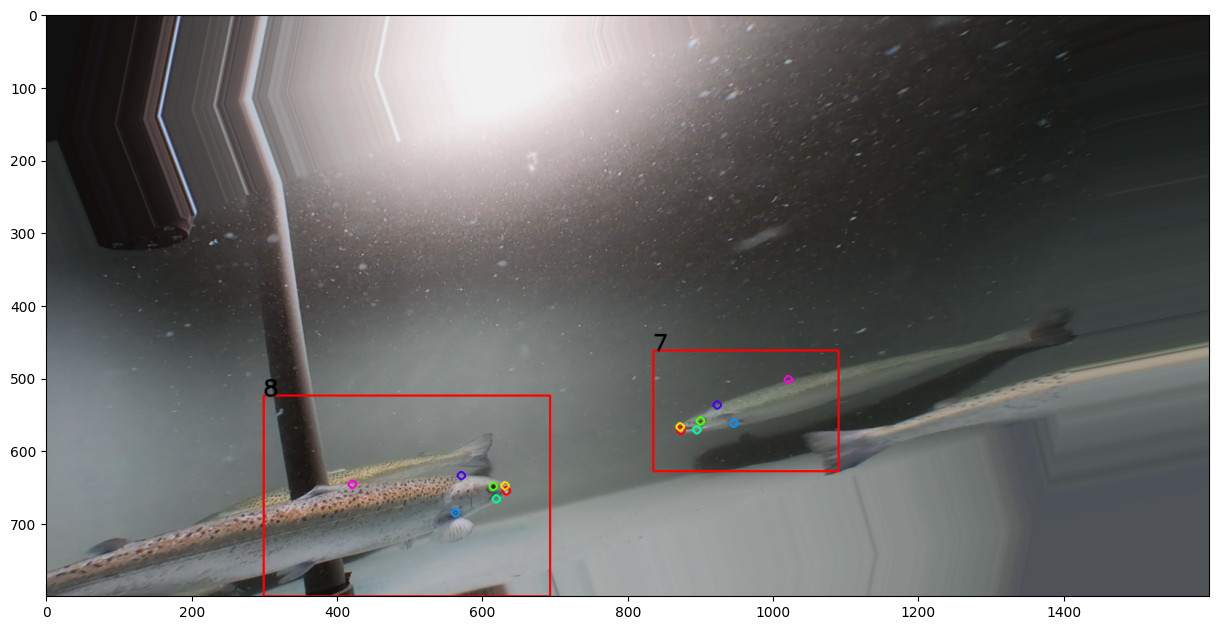

In [4]:
# View an example augmented image
import copy

exmp_img = 'frame1450'

# Load image and manual annotations from disk
img = cv2.imread(os.path.join(data_path_load, 'images', exmp_img + '.jpg'))
with open(os.path.join(data_path_load, 'labels', exmp_img + '.json'), 'r') as f:
    label = json.load(f)

# Change the format to accomodate for calling augmentor
label = labelme_to_alb_in(label)

# Call augmentor
augmented = augmentor(image=img, bboxes=label['bboxes'],
                      bbox_labels = label['bboxes'], 
                      bbox_id =  label['bbox_id'], 
                      keypoints = label['keypoints'], 
                      keypoint_labels=label['keypoint_labels'], 
                      keypoint_id=label['keypoint_id'])
                
# Display image
plt.figure(figsize=(15, 15))
plt.imshow(draw_label_on_alb_output(copy.deepcopy(augmented)))

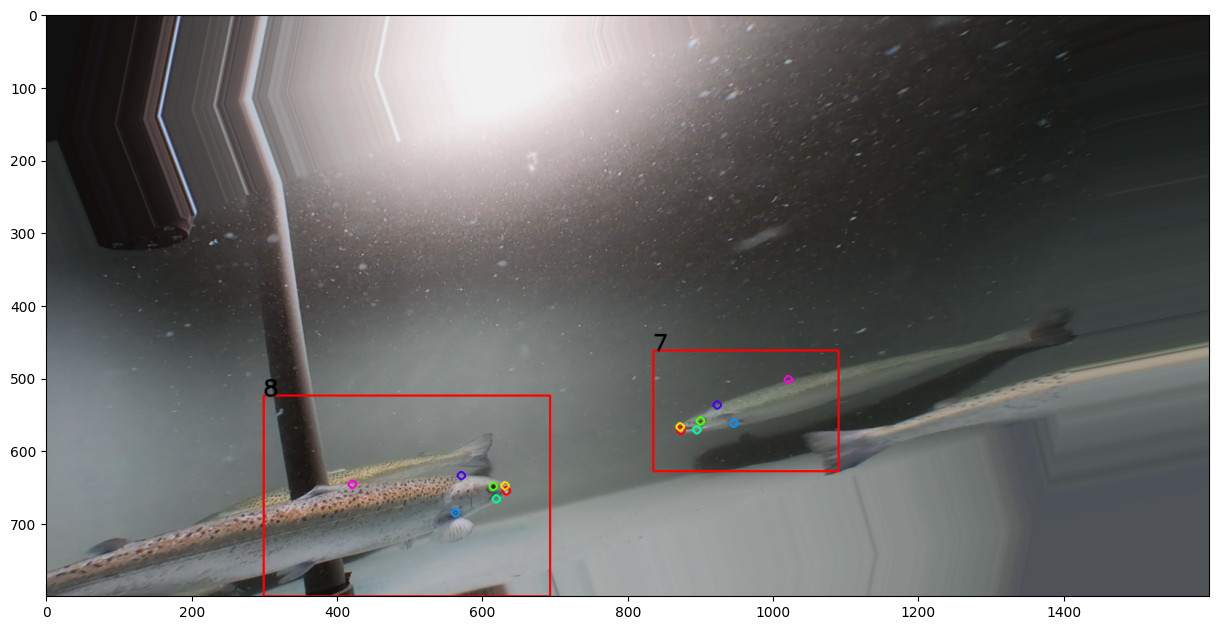

In [5]:
# View the changes from alb_out to keyrcnn_in.
# the main visible change is that incomplete labels are removed.

# alb_out to keyrcnn_in
keyrcnn_in_labels = alb_out_to_keyrcnn_in(copy.deepcopy(augmented))

# Plot keyrcnn_in
plt.figure(figsize=(15, 15))
plt.imshow(draw_label_on_keyrcnn_in(keyrcnn_in_labels, augmented['image']))


In [ ]:
# Create augmented dataset, and save to disk
inflation_ratio = 30
for image in os.listdir(os.path.join(data_path_load, 'images')):
    # Read in image
    img = cv2.imread(os.path.join(data_path_load, 'images', image))

    # Read in label
    label_path = os.path.join(data_path_load,'labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)
        label = labelme_to_alb_in(label)

    # Remove label if multipple occluded fish (since keypoint assignment to individual fish is non-trivial when several fish has the same class)
    if label is None:
        print('Image ', image, ' is removed due to multipple occluded fish')
    else:
        try: 
            # Augment image inflation_ratio times, and save to disk. If an image has no labels, try to augment it again
            succ = 0
            while succ < inflation_ratio:
                augmented = augmentor(image=img, bboxes=label['bboxes'],
                            bbox_labels = label['bboxes'], 
                            bbox_id =  label['bbox_id'], 
                            keypoints = label['keypoints'], 
                            keypoint_labels=label['keypoint_labels'], 
                            keypoint_id=label['keypoint_id'])
                label_key_rcnn_in = alb_out_to_keyrcnn_in(augmented)
                if len(label_key_rcnn_in['classes']) > 0:
                    cv2.imwrite(os.path.join(data_path_store, 'images', f'{image.split(".")[0]}.{succ}.jpg'), augmented['image']) # Save image
                    with open(os.path.join(data_path_store, 'labels', f'{image.split(".")[0]}.{succ}.json'), 'w') as f: # Save label
                        json.dump(label_key_rcnn_in, f)
                    succ = succ + 1

        except Exception as e:
            print(e)

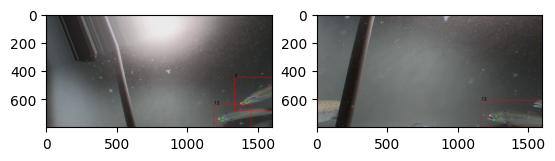

In [244]:
# View two images from the augmented dataset
imgs = ['frame2180.5', 'frame2180.9']
fig, ax = plt.subplots(1,2)
for i in range(len(imgs)):
    with open(os.path.join(data_path_store, 'labels', imgs[i] + '.json'), 'r') as f:
        label = json.load(f)
    img = cv2.imread(os.path.join(data_path_store, 'images', imgs[i] + '.jpg'))
    label['image'] = img
    ax[i].imshow(draw_label_on_keyrcnn_in(label, img))